## 3. LightGBM_GSCV

## Run name

In [1]:
import time

project_name = 'AtecAntiFraud'
step_name = 'LightGBM_GSCV'
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)
t0 = time.time()

run_name: AtecAntiFraud_LightGBM_GSCV_20180608_215621


## Important params

## Import PKGs

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from IPython.display import display
import seaborn as sns

import os
import sys
import gc
import math
import tqdm
import shutil
import zipfile
import pickle
import h5py
# import cv2
from PIL import Image

from tqdm import tqdm
import multiprocessing

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.utils import shuffle

random_num = np.random.randint(10000)
cpu_amount = multiprocessing.cpu_count()

print('cpu_amount: %s' % (cpu_amount - 1))
print('random_num: %s' % random_num)

C:\Users\study\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


cpu_amount: 3
random_num: 1109


In [3]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold

import xgboost
from xgboost import plot_importance

## Project folders

In [4]:
cwd = os.getcwd()
feature_folder = os.path.join(cwd, 'feature')
figure_folder = os.path.join(cwd, 'figure')
input_folder = os.path.join(cwd, 'input')
output_folder = os.path.join(cwd, 'output')
model_folder = os.path.join(cwd, 'model')

test_a_csv_file = os.path.join(input_folder, 'atec_anti_fraud_test_a.csv')
test_b_csv_file = os.path.join(input_folder, 'atec_anti_fraud_test_b.csv')
train_csv_file = os.path.join(input_folder, 'atec_anti_fraud_train.csv')
sample_submission_csv_file = os.path.join(input_folder, 'demo.csv')

print(test_a_csv_file)
print(test_b_csv_file)
print(train_csv_file)
print(sample_submission_csv_file)

D:\bitbucket\atecantifraud\input\atec_anti_fraud_test_a.csv
D:\bitbucket\atecantifraud\input\atec_anti_fraud_test_b.csv
D:\bitbucket\atecantifraud\input\atec_anti_fraud_train.csv
D:\bitbucket\atecantifraud\input\demo.csv


## Load data

In [5]:
dtypes = {
    'f1': 'uint8',
    'f2': 'uint8',
    'f3': 'uint8',
    'f4': 'uint8',
#    'f5': 'int64', #int64
    'f6': 'uint8',
    'f7': 'uint8',
    'f8': 'uint8',
    'f9': 'uint8',
    'f10': 'uint8',
    'f11': 'uint8',
    'f12': 'uint8',
    'f13': 'uint8',
    'f14': 'uint8',
    'f15': 'uint8',
    'f16': 'uint8',
    'f17': 'uint8',
    'f18': 'uint8',
    'f19': 'uint8',
    'f20': 'uint8',
}
dtypes = None

In [6]:
%%time
rows = 10000
# rows = None

train_csv = pd.read_csv(train_csv_file, nrows=rows, dtype=dtypes, parse_dates=['date'])
test_a_csv = pd.read_csv(test_a_csv_file, nrows=rows, dtype=dtypes, parse_dates=['date'])
sample_submission_csv = pd.read_csv(sample_submission_csv_file)

print(train_csv.shape)
print(test_a_csv.shape)
print(sample_submission_csv.shape)

display(train_csv.head())
display(test_a_csv.head())
display(sample_submission_csv.head())

(10000, 300)
(10000, 299)
(3, 2)


,id,label,date,f1,f2,f3,f4,f5,f6,f7,...,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297
0,f10eb20f31cf7063ee8bdbd1272214e4d7e0193c8dbce4...,0,2017-11-03,0,0,0,0,100807.0,0,5,...,301.0,312.0,328.0,85.0,302.0,201.0,203.0,203.0,61.0,201.0
1,d861929b67938d06538b910b9f6b85f5eb62b6ad7361ba...,0,2017-09-17,0,1,1,1,100805.0,1,5,...,302.0,324.0,391.0,13.0,302.0,160.0,160.0,161.0,8.0,160.0
2,1270cb8a85eedd57672b2c6297fa5633e36773a2c3a351...,0,2017-10-22,0,0,1,0,100102.0,0,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9fa009724ee7ff9d688ae321304fbc78f608cdabbfdd2b...,0,2017-10-29,0,0,0,1,100807.0,1,4,...,302.0,322.0,341.0,57.0,251.0,175.0,176.0,176.0,49.0,150.0
4,1da482485d7e8bcefae7e9d0d1167cec3ac111cfa71d8b...,0,2017-10-02,1,1,0,1,100805.0,1,5,...,302.0,301.0,301.0,74.0,302.0,182.0,181.0,182.0,51.0,181.0


,id,date,f1,f2,f3,f4,f5,f6,f7,f8,...,f288,f289,f290,f291,f292,f293,f294,f295,f296,f297
0,8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6f...,2018-01-20,0,0,1,1,100809.0,1,3,2,...,302.0,302.0,302.0,134.0,302.0,215.0,215.0,215.0,94.0,214.0
1,f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7...,2018-01-05,1,1,0,0,100808.0,1,5,2,...,39.0,40.0,40.0,39.0,40.0,39.0,39.0,39.0,39.0,39.0
2,ee85f808b1fd49eaba308527e1686c509dc8e3e5057488...,2018-01-09,0,0,0,0,100803.0,0,6,1,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,1.0,2.0
3,0df905aa187938d56a9b0816b13f54ac1f87d658a33cd0...,2018-01-18,1,1,1,1,100808.0,0,3,2,...,301.0,301.0,302.0,122.0,301.0,208.0,208.0,207.0,89.0,207.0
4,15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3e...,2018-01-09,1,1,1,1,100809.0,0,2,2,...,301.0,302.0,302.0,118.0,302.0,251.0,251.0,251.0,101.0,251.0


,id,score
0,e43b0d4dc42f55bf5def4b6155856d9494fb7626d43bba...,0.000648
1,c17d52961284a02589e5bb684caa38868191fdb64d4711...,0.000203
2,dcf26d76f6d77651fc1e85d0be5dd835f0871cb72a9b03...,0.001065


Wall time: 1.73 s


## Data type and describe

In [7]:
## preview columns
cols = train_csv.columns
print('col\tdata_type\tmax\tdata\t')
for col in cols:
    print(col, end='\t')
    print(train_csv[col].dtype, end='\t\t')
    print(max(train_csv[col]), end='\t')
    print(list(train_csv[col][:20]))
    for d in list(train_csv[col][:20]):
        if train_csv[col].dtype == 'float64' and d>0. and d != int(d):
            print('*'*80)
            break

col	data_type	max	data	
id	object		fff2e4edc7037a4f81b36f562f38e47aa033d6f54fded52379959833034f32dc	['f10eb20f31cf7063ee8bdbd1272214e4d7e0193c8dbce45ad14463036ff95d0a', 'd861929b67938d06538b910b9f6b85f5eb62b6ad7361ba36bd3bbce45609361c', '1270cb8a85eedd57672b2c6297fa5633e36773a2c3a351960e1c22b75074ea23', '9fa009724ee7ff9d688ae321304fbc78f608cdabbfdd2b06b73dc34e77c7bf80', '1da482485d7e8bcefae7e9d0d1167cec3ac111cfa71d8bb839b0ea17f9619b84', '81b481d377dc060f6c3249d086d28b0fb4c3781a72927da0ab3e01b8956b7f25', 'cda7677920fc9bad4bb727ed8a87f59e3400572f75fd46f6a4cbb072cb069bc9', '19d100ff146a203f0e558fd60534b8ece650be4ecb4564b5ab7a11a855741893', '49ff13e491c3e4c680cdf39e9b3b85560a4bb80994ac63bc6bacb5791e68967e', 'ee3adc3a1b88a30297f86cf77c0fcd1d5c17653f1a982882f5b6ae1257bd32ab', '741b5ae5f9f722faca496194ace8bc7920edb8fa1d4477b3fd130be6fe929397', '2739260b670d0656e3dd9c2709dd91da76677727d19470d4fd6b4e4588c94b29', 'fa592b16296ad2b2af574bca9d07a48cb2e5fc4e213a34b3f4af1ddde4845ebd', '6970c7e69aaec5

f56	float64		257.0	[1.0, 4.0, nan, 3.0, 1.0, 3.0, nan, 1.0, 1.0, 6.0, 95.0, 1.0, 1.0, 2.0, nan, 5.0, nan, 3.0, nan, nan]
f57	float64		316.0	[1.0, 4.0, nan, 6.0, 1.0, 3.0, nan, 2.0, 1.0, 10.0, 95.0, 1.0, 2.0, 2.0, nan, 7.0, nan, 2.0, nan, nan]
f58	float64		315.0	[2.0, 5.0, nan, 5.0, 2.0, 2.0, nan, 2.0, 1.0, 24.0, 95.0, 2.0, 1.0, 1.0, nan, 7.0, nan, 2.0, nan, nan]
f59	float64		3.0	[2.0, 1.0, nan, 1.0, 2.0, 1.0, nan, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, nan, 1.0, nan, 1.0, nan, nan]
f60	float64		3.0	[1.0, 1.0, nan, 2.0, 2.0, 1.0, nan, 2.0, 1.0, 3.0, 2.0, 2.0, 1.0, 2.0, nan, 1.0, nan, 1.0, nan, nan]
f61	float64		9.0	[2.0, 4.0, nan, 3.0, 2.0, 2.0, nan, 2.0, 1.0, 5.0, 2.0, 1.0, 2.0, 2.0, nan, 4.0, nan, 2.0, nan, nan]
f62	float64		17.0	[2.0, 3.0, nan, 6.0, 1.0, 1.0, nan, 1.0, 1.0, 8.0, 2.0, 1.0, 1.0, 1.0, nan, 6.0, nan, 1.0, nan, nan]
f63	float64		31.0	[3.0, 3.0, nan, 6.0, 1.0, 2.0, nan, 2.0, 2.0, 17.0, 1.0, 2.0, 1.0, 1.0, nan, 6.0, nan, 1.0, nan, nan]
f64	float64		243.0	[96.0, 79.0, nan, nan, 

f117	float64		247.0	[191.0, 121.0, nan, nan, 217.0, 2.0, 228.0, nan, 2.0, 193.0, nan, 1.0, 1.0, nan, 2.0, 2.0, nan, 1.0, nan, nan]
f118	float64		246.0	[192.0, 122.0, nan, nan, 218.0, 2.0, 227.0, nan, 1.0, 193.0, nan, 2.0, 1.0, nan, 2.0, 1.0, nan, 1.0, nan, nan]
f119	float64		247.0	[191.0, 121.0, nan, nan, 217.0, 2.0, 227.0, nan, 1.0, 192.0, nan, 2.0, 2.0, nan, 2.0, 2.0, nan, 2.0, nan, nan]
f120	float64		246.0	[190.0, 16.0, nan, nan, 177.0, 2.0, 224.0, nan, 2.0, 190.0, nan, 1.0, 1.0, nan, 2.0, 1.0, nan, 1.0, nan, nan]
f121	float64		246.0	[190.0, 121.0, nan, nan, 216.0, 2.0, 224.0, nan, 1.0, 191.0, nan, 2.0, 2.0, nan, 1.0, 2.0, nan, 1.0, nan, nan]
f122	float64		246.0	[190.0, 122.0, nan, nan, 216.0, 1.0, 225.0, nan, 2.0, 191.0, nan, 2.0, 2.0, nan, 2.0, 2.0, nan, 1.0, nan, nan]
f123	float64		37.0	[32.0, 32.0, nan, nan, 35.0, 2.0, 34.0, nan, 1.0, 33.0, nan, 1.0, 2.0, nan, 2.0, 2.0, nan, 2.0, nan, nan]
f124	float64		37.0	[33.0, 31.0, nan, nan, 34.0, 1.0, 35.0, nan, 1.0, 35.0, nan, 2.0, 2.0, 

f182	float64		7.0	[2.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 2.0, 1.0, 4.0, 1.0, 1.0, 2.0, 2.0, 1.0, 3.0, 2.0, 2.0, 1.0, 3.0]
f183	float64		10.0	[4.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 2.0, 2.0, 4.0, 3.0, 1.0, 2.0, 2.0, 2.0, 5.0, 2.0, 2.0, 1.0, 2.0]
f184	float64		14.0	[3.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 4.0, 3.0, 2.0, 3.0, 3.0, 2.0, 5.0, 3.0, 2.0, 2.0, 3.0]
f185	float64		20.0	[4.0, 2.0, 3.0, 2.0, 1.0, 2.0, 3.0, 1.0, 3.0, 4.0, 3.0, 2.0, 2.0, 5.0, 3.0, 4.0, 3.0, 2.0, 2.0, 2.0]
f186	float64		2.0	[2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 2.0]
f187	float64		4.0	[1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0]
f188	float64		5.0	[1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0]
f189	float64		5.0	[1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
f190	float64		5.0	[2.0, 1.0, 2.0, 2.0, 1.0, 2

f248	float64		312.0	[16.0, 2.0, 13.0, 2.0, 3.0, 7.0, 8.0, 7.0, 1.0, 1.0, 94.0, 2.0, 9.0, 2.0, 4.0, 143.0, 301.0, 2.0, 2.0, 301.0]
f249	float64		146.0	[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 2.0, 5.0, 70.0, 2.0, 2.0, 82.0]
f250	float64		277.0	[2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 8.0, 127.0, 1.0, 2.0, 242.0]
f251	float64		276.0	[4.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 22.0, 235.0, 2.0, 1.0, 242.0]
f252	float64		277.0	[5.0, 1.0, 4.0, 1.0, 2.0, 2.0, 1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 54.0, 236.0, 2.0, 2.0, 241.0]
f253	float64		277.0	[7.0, 1.0, 6.0, 1.0, 2.0, 2.0, 1.0, 5.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 66.0, 235.0, 2.0, 2.0, 242.0]
f254	float64		3.0	[2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0]
f255	float64		4.0	[2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
f256	f

In [8]:
# train_max = train_csv.max()
# print(train_max.shape)
# display(train_max)

## Filter

In [9]:
true_train_csv = train_csv[train_csv['label'] == 0]
false_train_csv = train_csv[train_csv['label'] == 1]
black_train_csv = train_csv[train_csv['label'] == -1]
train_csv = train_csv[train_csv['label'] != -1]

print(true_train_csv.shape)
print(false_train_csv.shape)
print(true_train_csv.shape[0]/false_train_csv.shape[0])
print(black_train_csv.shape)
print(train_csv.shape)

(9832, 300)
(112, 300)
87.78571428571429
(56, 300)
(9944, 300)


## Feature

In [10]:
## date
def do_date(df):
    df['year'] = df['date'].dt.year.astype('uint16')
    df['month'] = df['date'].dt.month.astype('uint8')
    df['day'] = df['date'].dt.day.astype('uint8')
    df['weekday'] = df['date'].dt.weekday.astype('uint8')
    return df

train_csv = do_date(train_csv)
test_a_csv = do_date(test_a_csv)

train_csv = train_csv.drop(columns=['date'])
test_a_csv = test_a_csv.drop(columns=['date'])

pass

In [11]:
## preview columns again
cols = train_csv.columns
print('col\tdata_type\tmax\tdata\t')
for col in cols[-5:]:
    print(col, end='\t')
    print(train_csv[col].dtype, end='\t\t')
    print(max(train_csv[col]), end='\t')
    print(list(train_csv[col][:10]))

col	data_type	max	data	
f297	float64		298.0	[201.0, 160.0, nan, 150.0, 181.0, 2.0, 240.0, 188.0, 2.0, 116.0]
year	uint16		2017	[2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017, 2017]
month	uint8		11	[11, 9, 10, 10, 10, 10, 9, 10, 9, 10]
day	uint8		31	[3, 17, 22, 29, 2, 12, 27, 27, 26, 11]
weekday	uint8		6	[4, 6, 6, 6, 0, 3, 2, 4, 1, 2]


## Prepare x_data

In [12]:
id_data = train_csv['id']
id_test_a = test_a_csv['id']
train_csv = train_csv.drop(columns=['id'])
test_a_csv = test_a_csv.drop(columns=['id'])

y_data = train_csv['label']
train_csv = train_csv.drop(columns=['label'])

useless_features = []
x_data = train_csv.drop(columns=useless_features)
x_test_a = test_a_csv.drop(columns=useless_features)

print(train_csv.shape)
print(test_a_csv.shape)

print(id_data.shape)
print(id_test_a.shape)

print(y_data.shape)
print(x_data.shape)
print(x_test_a.shape)

(9944, 301)
(10000, 301)
(9944,)
(10000,)
(9944,)
(9944, 301)
(10000, 301)


## Split data

In [13]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=random_num, shuffle=True)

# x_train, y_train = shuffle(x_train, y_train, random_state=random_num)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(8949, 301)
(8949,)
(995, 301)
(995,)


## Train

In [14]:
%%time
import warnings
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV

# lgb_train = lgb.Dataset(x_train, label=y_train)
# lgb_val = lgb.Dataset(x_val, label=y_val, reference=lgb_train)

# LightGBM parameters
param_grid = {
#     'task': 'train',
#     'num_boost_round': [200],
#     'early_stopping_rounds': [10],
#     'boosting_type': ['gbdt'], # (default="gbdt")
#     'num_leaves': [300], # (default=31)
    'max_depth': [6, 8, 10], # (default=-1)
#     'learning_rate': [0.1], # (default=0.1)
    'n_estimators': [1000, 500], # (default=10)
#     'max_bin': [1000, 255], # (default=255)
#     'subsample_for_bin': [100*10000], # (default=50000)
#     'objective': ['binary'], # (default=None)
#     'min_split_gain': [0.], # (default=0.)
#     'min_child_weight': [1e-3], # (default=1e-3)
#     'min_child_samples': [10], # (default=20)
#     'subsample': [0.7], # (default=1.)
#     'subsample_freq': [1], # (default=1)
#     'colsample_bytree': [0.9], # (default=1.)
#     'reg_alpha': [0., 0.3], # (default=0.)
#     'reg_lambda': [0., 0.3], # (default=0.)
#     'random_state': [random_num], # (default=None)
#     'n_jobs': [-1], # (default=-1)
#     'silent': [False], # (default=True)
#     'metric': ['auc', 'binary_logloss'],
}
# print('params: ', params)
# train
clf = lgb.LGBMClassifier(
#     'num_boost_round'=200,
#     'early_stopping_rounds'=10,
    boosting_type='gbdt', # (default="gbdt")
    num_leaves=512, # (default=31)
    max_depth=5, # (default=-1)
    learning_rate=0.1, # (default=0.1)
    n_estimators=500, # (default=10)
#     max_bin=255, # (default=255)
    subsample_for_bin=500, # (default=50000)
    objective='binary', # (default=None)
    class_weight=None,
    min_split_gain=0., # (default=0.)
    min_child_weight=1e-3, # (default=1e-3)
    min_child_samples=20, # (default=20)
    subsample=0.5, # (default=1.)
#     subsample_freq=1, # (default=1)
    colsample_bytree=0.1, # (default=1.)
    reg_alpha=0., # (default=0.)
    reg_lambda=0., # (default=0.)
    random_state=random_num, # (default=None)
    n_jobs=-1, # (default=-1)
    silent=False, # (default=True)
#     'metric'=['auc', 'binary_logloss'],
)
# gbm = lgb.train(
#     params,
#     train_set=lgb_train,
#     valid_sets=lgb_val
# )
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, n_jobs=1, scoring='roc_auc')
grid_search.fit(x_train, y_train)

Wall time: 1min 24s


In [15]:
%%time

print('*' * 80)
y_train_proba = grid_search.predict_proba(x_train)
print(y_train.shape)
print(y_train_proba.shape)
print(y_train_proba[:10])
y_train_pred = (y_train_proba[:, 1]>=0.5).astype(int)
acc_train = accuracy_score(y_train, y_train_pred)
roc_train = roc_auc_score(y_train, y_train_proba[:, 1])
print('acc_train: %.4f \t roc_train: %.4f' % (acc_train, roc_train))

# y_train_pred = grid_search.predict(x_train)
# acc_train = accuracy_score(y_train, y_train_pred)
# roc_train = roc_auc_score(y_train, y_train_proba[:, 1])
# print('acc_train: %.4f \t roc_train: %.4f' % (acc_train, roc_train))

y_val_proba = grid_search.predict_proba(x_val)
print(y_val.shape)
print(y_val_proba.shape)
print(y_val_proba[:10])
y_val_pred = (y_val_proba[:, 1]>=0.5).astype(int)
print(y_val.shape)
print(y_val_pred.shape)
acc_val = accuracy_score(y_val, y_val_pred)
roc_val = roc_auc_score(y_val, y_val_proba[:, 1])
print('acc_val:   %.4f \t roc_val:   %.4f' % (acc_val, roc_val))

********************************************************************************
(8949,)
(8949, 2)
[[9.99999998e-01 1.88621027e-09]
 [9.99999999e-01 9.15955352e-10]
 [9.99999674e-01 3.26071683e-07]
 [9.99974315e-01 2.56853263e-05]
 [9.99999987e-01 1.26482751e-08]
 [9.99999987e-01 1.34556777e-08]
 [9.99999998e-01 1.97655564e-09]
 [9.99999998e-01 1.70503779e-09]
 [9.99999997e-01 2.63071777e-09]
 [9.99999992e-01 7.88582052e-09]]
acc_train: 1.0000 	 roc_train: 1.0000
(995,)
(995, 2)
[[9.99999992e-01 7.64465449e-09]
 [1.00000000e+00 1.00989408e-10]
 [1.00000000e+00 8.03801505e-11]
 [9.99999992e-01 8.13728441e-09]
 [1.00000000e+00 3.41824460e-11]
 [1.00000000e+00 9.02762622e-11]
 [9.99999997e-01 2.95652296e-09]
 [9.99999991e-01 9.18858933e-09]
 [9.99999993e-01 6.81683748e-09]
 [9.99999989e-01 1.08935817e-08]]
(995,)
(995,)
acc_val:   0.9930 	 roc_val:   0.9942
Wall time: 550 ms


In [16]:
print(grid_search.cv_results_)
print('*' * 60)
print(grid_search.grid_scores_ )
print(grid_search.best_estimator_)
print(grid_search.best_score_)
print(grid_search.best_params_)
print(grid_search.scorer_)
print('*' * 60)
print(type(grid_search.best_estimator_))
print(dir(grid_search.best_estimator_))

{'mean_fit_time': array([5.36833517, 2.82133301, 4.72333296, 3.02866586, 5.18899671,
       3.34533175]), 'std_fit_time': array([0.67869204, 0.32097461, 0.30276039, 0.23311828, 0.55258085,
       0.5621679 ]), 'mean_score_time': array([0.14199766, 0.09733661, 0.12600176, 0.10133417, 0.1253349 ,
       0.10166907]), 'std_score_time': array([0.03256754, 0.01247069, 0.01349183, 0.01470591, 0.001249  ,
       0.01087265]), 'param_max_depth': masked_array(data=[6, 6, 8, 8, 10, 10],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_n_estimators': masked_array(data=[1000, 500, 1000, 500, 1000, 500],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'max_depth': 6, 'n_estimators': 1000}, {'max_depth': 6, 'n_estimators': 500}, {'max_depth': 8, 'n_estimators': 1000}, {'max_depth': 8, 'n_estimators': 500}, {'max_depth': 10, 'n_estimators': 1000}, {'max_dep

In [17]:
cv_results = pd.DataFrame(grid_search.cv_results_)
display(cv_results)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,5.368335,0.141998,0.966955,1.0,6,1000,"{'max_depth': 6, 'n_estimators': 1000}",6,0.956198,1.0,0.980626,1.0,0.964043,1.0,0.678692,0.032568,0.010184,0.0
1,2.821333,0.097337,0.969225,1.0,6,500,"{'max_depth': 6, 'n_estimators': 500}",2,0.958107,1.0,0.981527,1.0,0.968044,1.0,0.320975,0.012471,0.009599,0.0
2,4.723333,0.126002,0.968104,1.0,8,1000,"{'max_depth': 8, 'n_estimators': 1000}",5,0.959938,1.0,0.979095,1.0,0.965281,1.0,0.302760,0.013492,0.008072,0.0
3,3.028666,0.101334,0.968913,1.0,8,500,"{'max_depth': 8, 'n_estimators': 500}",3,0.960626,1.0,0.979957,1.0,0.966159,1.0,0.233118,0.014706,0.008129,0.0
4,5.188997,0.125335,0.968717,1.0,10,1000,"{'max_depth': 10, 'n_estimators': 1000}",4,0.965974,1.0,0.980452,1.0,0.959723,1.0,0.552581,0.001249,0.008681,0.0
5,3.345332,0.101669,0.969355,1.0,10,500,"{'max_depth': 10, 'n_estimators': 500}",1,0.968493,1.0,0.978649,1.0,0.960921,1.0,0.562168,0.010873,0.007263,0.0


In [18]:
fe_times = grid_search.best_estimator_.booster_.feature_importance()
fe_name = grid_search.best_estimator_.booster_.feature_name()
print(fe_times)
print(fe_name)

[ 58 108  74 100 109 111 148 116 121 122 124 115 147 156 146 117 182 105
 135  52  68  61  59  52  42  36  39  23  47  21  37 119  48  74  48   1
   1   8   4   3   3   2   6   1   3   0   3 106  50  56  65  51  45  34
  35  77  67  49  32  34  40  37  44  37  37  40  44  18  42  33  37  59
 120  39  90  65  57  99  51 138  59 160 127 110 127 115  26  16  22  35
  31   5  20  24  27  41  56  37  53  89 132  53  56 108  81 164  67  63
 107 117  48  34  25  13  33  32  22  19  23  22  32  15  15  19  22  14
  19  31  28  25  36  26  24  34  13  20  27  29  16  27   8  51  34  17
  24  31  21  30  19  13  45  28  30  73  16   7  18  12  11  12 169 159
 120 127  94  38  22  23  38  42  32  25  46  20  23  40  25  45  36  38
  34  34  57  58  66  19  43  30  30  34  21  21  38  21  18  21  34  32
  23  15  27  22  18  89  75 105 137 163  64 146 115 114 123 156 213 255
 242 354 105 113 128 108 101 152 143 103 138 106 136 140 108 165 137 216
 220 200 242 225 117 138 184 181 153 279 190 320 26

,feature,importance
0,f1,58
1,f2,108
2,f3,74
3,f4,100
4,f5,109


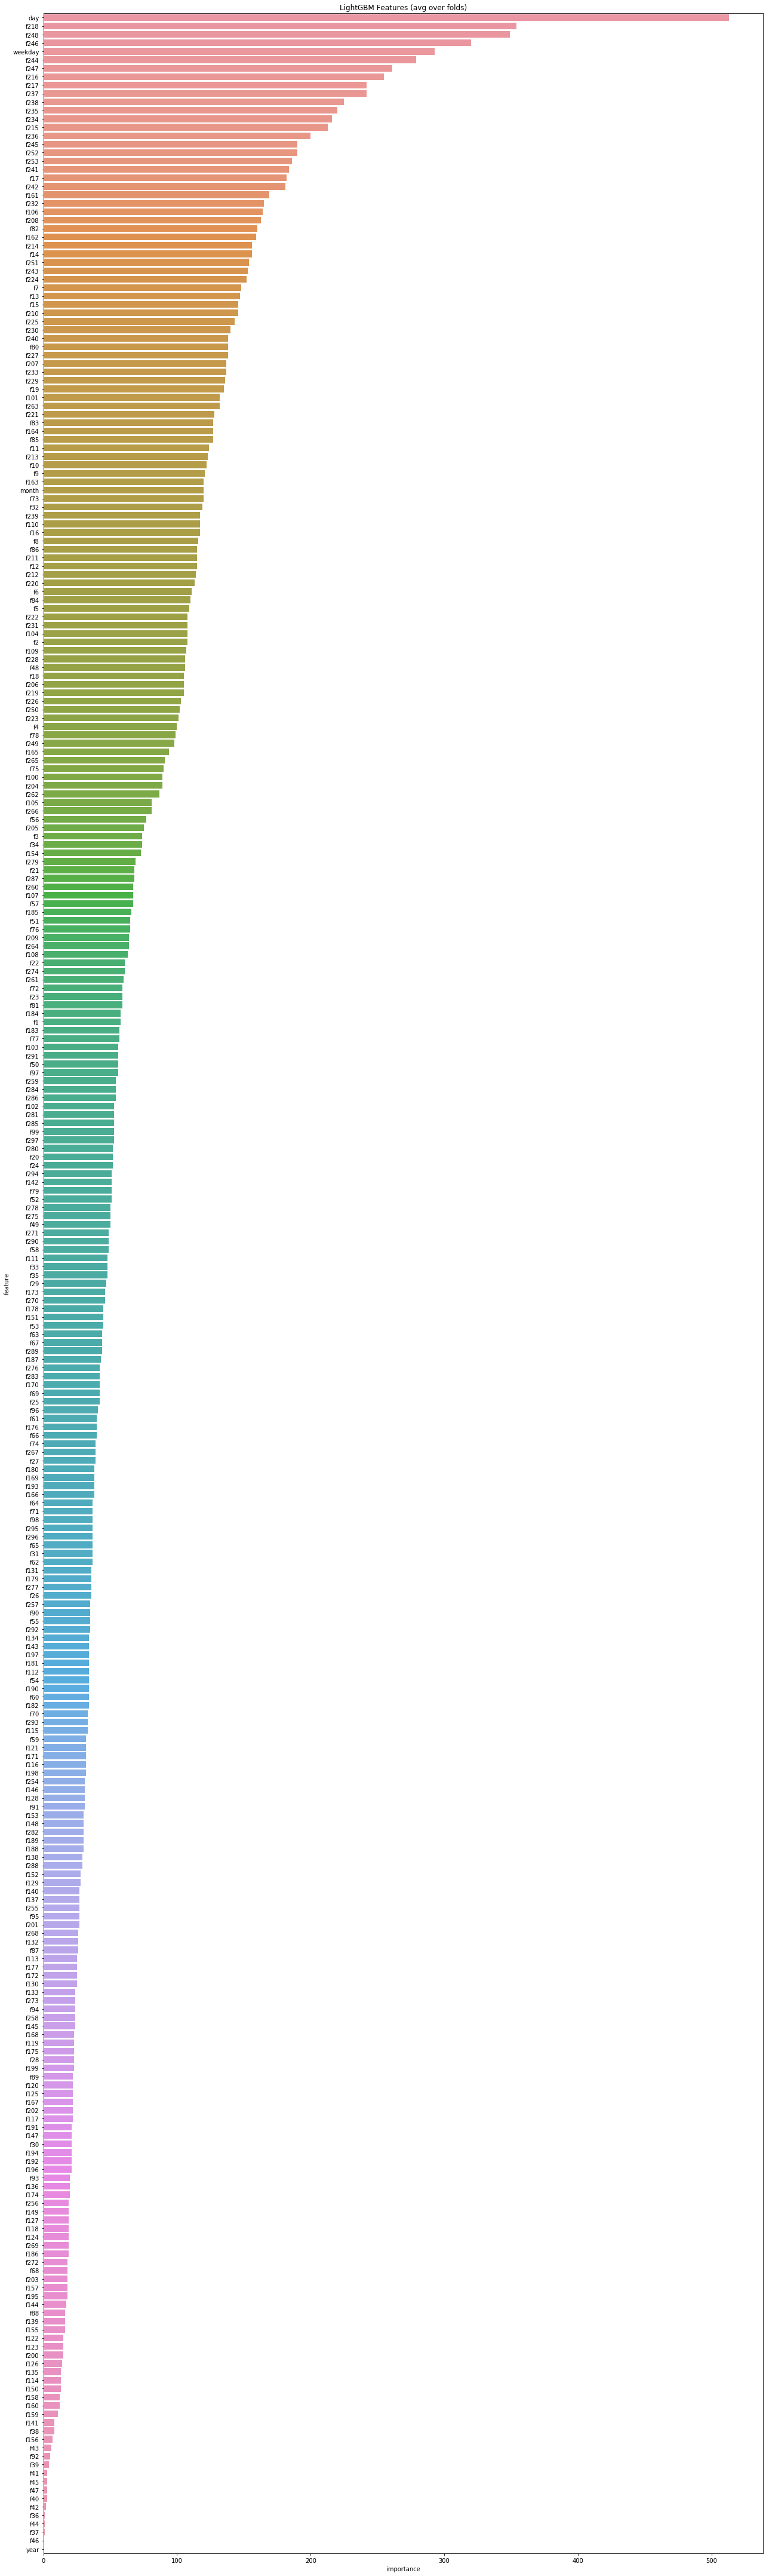

In [19]:
importance_score = pd.DataFrame(data={'feature': fe_name, 'importance': fe_times})
display(importance_score.head())

plt.figure(figsize=(18,60))
# sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
sns.barplot(x="importance", y="feature", data=importance_score.sort_values(by="importance", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()

In [20]:
importance_score=importance_score.sort_values(by='importance', ascending=False)
display(importance_score['feature'][:5])
for item in importance_score.values:
    print('%s\t%s' % (item[1], item[0]))

299        day
217       f218
247       f248
245       f246
300    weekday
Name: feature, dtype: object

513	day
354	f218
349	f248
320	f246
293	weekday
279	f244
261	f247
255	f216
242	f217
242	f237
225	f238
220	f235
216	f234
213	f215
200	f236
190	f245
190	f252
186	f253
184	f241
182	f17
181	f242
169	f161
165	f232
164	f106
163	f208
160	f82
159	f162
156	f214
156	f14
154	f251
153	f243
152	f224
148	f7
147	f13
146	f15
146	f210
143	f225
140	f230
138	f240
138	f80
138	f227
137	f207
137	f233
136	f229
135	f19
132	f101
132	f263
128	f221
127	f83
127	f164
127	f85
124	f11
123	f213
122	f10
121	f9
120	f163
120	month
120	f73
119	f32
117	f239
117	f110
117	f16
116	f8
115	f86
115	f211
115	f12
114	f212
113	f220
111	f6
110	f84
109	f5
108	f222
108	f231
108	f104
108	f2
107	f109
106	f228
106	f48
105	f18
105	f206
105	f219
103	f226
102	f250
101	f223
100	f4
99	f78
98	f249
94	f165
91	f265
90	f75
89	f100
89	f204
87	f262
81	f105
81	f266
77	f56
75	f205
74	f3
74	f34
73	f154
69	f279
68	f21
68	f287
67	f260
67	f107
67	f57
66	f185
65	f51
65	f76
64	f209
64	f264
63	f108
61	f22
61	f274
60	f261
59	f72
59	f23
59	f81
58	f184
58	f1
5

## Predict

In [21]:
run_name_acc = run_name + '_' + str(int(roc_val*10000)).zfill(4)
print(run_name_acc)

AtecAntiFraud_LightGBM_GSCV_20180608_215621_9941


In [22]:
y_test_a_proba = grid_search.predict_proba(x_test_a)

print(y_test_a_proba.shape)
print(y_test_a_proba[:10])

y_test_a_proba_true = y_test_a_proba[:, 1]

print(y_test_a_proba_true.shape)
print(y_test_a_proba_true[:10])

(10000, 2)
[[9.99999999e-01 1.22753387e-09]
 [9.99887552e-01 1.12447566e-04]
 [1.00000000e+00 2.68651517e-10]
 [9.99999963e-01 3.67984310e-08]
 [9.99999992e-01 8.11913689e-09]
 [9.99999849e-01 1.50593093e-07]
 [9.99999992e-01 8.34461329e-09]
 [9.99999993e-01 7.28362532e-09]
 [9.99999483e-01 5.17238379e-07]
 [9.99999949e-01 5.14487179e-08]]
(10000,)
[1.22753387e-09 1.12447566e-04 2.68651517e-10 3.67984310e-08
 8.11913689e-09 1.50593093e-07 8.34461329e-09 7.28362532e-09
 5.17238379e-07 5.14487179e-08]


In [23]:
y_data_proba = grid_search.predict_proba(x_data)

print(y_data_proba.shape)
print(y_data_proba[:10])

y_data_proba_true = y_data_proba[:, 1]

print(y_data_proba_true.shape)
print(y_data_proba_true[:10])

(9944, 2)
[[1.00000000e+00 1.57141346e-10]
 [9.99999999e-01 1.23950963e-09]
 [1.00000000e+00 3.21757958e-10]
 [9.99999969e-01 3.07963747e-08]
 [9.99999986e-01 1.36415062e-08]
 [9.99999580e-01 4.19539915e-07]
 [9.99999992e-01 8.15081791e-09]
 [1.00000000e+00 4.67497089e-10]
 [9.99999999e-01 1.04947063e-09]
 [9.99999994e-01 5.60135013e-09]]
(9944,)
[1.57141346e-10 1.23950963e-09 3.21757958e-10 3.07963747e-08
 1.36415062e-08 4.19539915e-07 8.15081791e-09 4.67497089e-10
 1.04947063e-09 5.60135013e-09]


In [24]:
def save_proba(y_data_proba, y_data, y_test_a_proba, id_test_a, file_name):
    id_test_a = [id_str.encode('utf-8') for id_str in id_test_a]
    print(id_test_a[:5])
    if os.path.exists(file_name):
        os.remove(file_name)
        print('File removed: %s' % file_name)
    with h5py.File(file_name) as h:
        h.create_dataset('y_data_proba', data=y_data_proba)
        h.create_dataset('y_data', data=y_data)
        h.create_dataset('y_test_a_proba', data=y_test_a_proba)
        h.create_dataset('id_test_a', data=id_test_a)
    print('File saved:   %s' % file_name)

def load_proba(file_name):
    with h5py.File(file_name, 'r') as h:
        y_data_proba = np.array(h['y_data_proba'])
        y_data = np.array(h['y_data'])
        y_test_a_proba = np.array(h['y_test_a_proba'])
        id_test_a = np.array(h['id_test_a'])
    print('File loaded:  %s' % file_name)
    id_test_a = [id_str.decode('utf-8') for id_str in id_test_a]
    print(id_test_a[:5])
    
    return y_data_proba, y_data, y_test_a_proba, id_test_a


y_proba_file = os.path.join(model_folder, 'proba_a_%s.p' % run_name_acc)
save_proba(
    y_data_proba, 
    y_data, 
    y_test_a_proba, 
    list(id_test_a),
    y_proba_file
)
y_data_proba, y_data, y_test_a_proba, id_test_a = load_proba(y_proba_file)

print('*'*80)
print(y_data_proba.shape)
print(y_data_proba[:10])
y_data_proba_true = y_data_proba[:, 1]
print(y_data_proba_true.shape)
print(y_data_proba_true[:10])

print('*'*80)
print(y_test_a_proba.shape)
print(y_test_a_proba[:10])
print(len(id_test_a))
y_test_a_proba_true = y_test_a_proba[:, 1]
print(y_test_a_proba_true.shape)
print(y_test_a_proba_true[:10])

[b'8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6fda5578f0e340908fa4', b'f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7c335237327bb02e02b', b'ee85f808b1fd49eaba308527e1686c509dc8e3e50574888e0f5f8bc21733711c', b'0df905aa187938d56a9b0816b13f54ac1f87d658a33cd06505b738c66b54fd3f', b'15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3ee00755b4949ef75c03']
File saved:   D:\bitbucket\atecantifraud\model\proba_a_AtecAntiFraud_LightGBM_GSCV_20180608_215621_9941.p
File loaded:  D:\bitbucket\atecantifraud\model\proba_a_AtecAntiFraud_LightGBM_GSCV_20180608_215621_9941.p
['8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6fda5578f0e340908fa4', 'f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7c335237327bb02e02b', 'ee85f808b1fd49eaba308527e1686c509dc8e3e50574888e0f5f8bc21733711c', '0df905aa187938d56a9b0816b13f54ac1f87d658a33cd06505b738c66b54fd3f', '15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3ee00755b4949ef75c03']
********************************************************************************
(9944, 2)
[[1.000000

In [25]:
# %%time
submission_csv_file = os.path.join(output_folder, 'pred_a_%s.csv' % run_name_acc)
print(submission_csv_file)
submission_csv = pd.DataFrame({ 'id': id_test_a , 'score': y_test_a_proba_true })
submission_csv.to_csv(submission_csv_file, index = False)
display(submission_csv.head())

D:\bitbucket\atecantifraud\output\pred_a_AtecAntiFraud_LightGBM_GSCV_20180608_215621_9941.csv


,id,score
0,8e8290c270ec4bc3448dd5edd35c6f059b42d38f9ddd6f...,1.227534e-09
1,f36c5fa5c0e7afccf733a4d74c7e06ffe43cc8fd24eda7...,1.124476e-04
2,ee85f808b1fd49eaba308527e1686c509dc8e3e5057488...,2.686515e-10
3,0df905aa187938d56a9b0816b13f54ac1f87d658a33cd0...,3.679843e-08
4,15f532f979c4f092bbbe28e5409c8c3b8454ece8f1ab3e...,8.119137e-09


In [26]:
print('Time cost: %.2f s' % (time.time() - t0))

print('random_num: ', random_num)
print(run_name_acc)
print('Done!')

Time cost: 107.81 s
random_num:  1109
AtecAntiFraud_LightGBM_GSCV_20180608_215621_9941
Done!
